In [1]:
import numpy as np
from sklearn.decomposition import PCA

In [2]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import scipy.stats as st
import wotan

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [264]:
from astropy.table import Table,join,vstack,unique

# PCA on Summary Table
- included more columns in ML_Tests notebook

In [3]:
#load in summary table
summ = pd.read_csv('summtab.csv')

In [4]:
summ[summ==0]=np.nan

In [5]:
summ.columns

Index(['src_n', 'ra_deg', 'dec_deg', 'spin period', 'perr', 'est. period',
       'sep', 'name', 'mean I', 'stdev I', 'max I', 'min I', 'I range',
       'mean V', 'stdev V', 'max V', 'min V', 'V range', 'est. period method',
       'best period', 'best superorbital', 'other period', 'period shape',
       'big dip', 'orbital cont', 'superorbital cont', 'mult superorbital',
       'changing superorbital amp', 'redder when brighter', 'I V-I corr',
       'V V-I corr', 'I V-I slope', 'I V-I int', 'V V-I slope', 'V V-I int',
       'V-I transition', 'Type II amp', 'note', 'I skew', 'I kurtosis',
       'V skew', 'V kurtosis', 'best auto det pd', 'Part', 'I IQR'],
      dtype='object')

In [186]:
def fullpca(tab,features,n=2,retdf=False,addpart=True):
    '''Standardize features and perform pca with n components'''
    #only keep rows where feature is not a nan
    df = tab[np.isnan(tab[features[0]])==False]
    #loop through remaining features
    for f in features[1:]:
        df = df[np.isnan(df[f])==False]
    print(len(df))
    x = df.loc[:, features]
    # Separating out the target
    y = df.loc[:,['src_n']]
    # Standardizing the features
    x = StandardScaler().fit_transform(x)
    #perform PCA with n components
    pca = PCA(n_components=n)
    principalComponents = pca.fit_transform(x)
    columns = ['']*n
    for c in range(1,n+1):
        columns[c-1] = f'pc {c}'
    pdf = pd.DataFrame(data = principalComponents, columns = columns)
    #add part to pdf
    if addpart:
        part = np.array(df['Part'])
        pdf['Part'] = part
    print(f'explained variance by component:{pca.explained_variance_ratio_}')
    if retdf: return df,pdf
    else: return pdf

In [11]:
features = ['best auto det pd','mean I','stdev I','I range','I V-I corr','I V-I slope',
           'I skew','I kurtosis','I IQR']
df,pdf = fullpca(summ,features,5,retdf=True)

106
explained variance by component:[0.34304108 0.20225359 0.16106579 0.10970198 0.09527732]


Text(0.5, 0, 'PC 1')

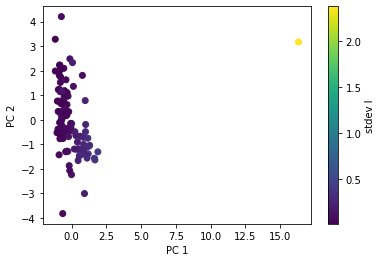

In [12]:
plt.scatter(pdf['pc 1'],pdf['pc 2'],c=df['stdev I'])
plt.colorbar(label='stdev I')
plt.ylabel('PC 2')
plt.xlabel('PC 1')

In [13]:
summ.columns

Index(['src_n', 'ra_deg', 'dec_deg', 'spin period', 'perr', 'est. period',
       'sep', 'name', 'mean I', 'stdev I', 'max I', 'min I', 'I range',
       'mean V', 'stdev V', 'max V', 'min V', 'V range', 'est. period method',
       'best period', 'best superorbital', 'other period', 'period shape',
       'big dip', 'orbital cont', 'superorbital cont', 'mult superorbital',
       'changing superorbital amp', 'redder when brighter', 'I V-I corr',
       'V V-I corr', 'I V-I slope', 'I V-I int', 'V V-I slope', 'V V-I int',
       'V-I transition', 'Type II amp', 'note', 'I skew', 'I kurtosis',
       'V skew', 'V kurtosis', 'best auto det pd', 'Part', 'I IQR'],
      dtype='object')

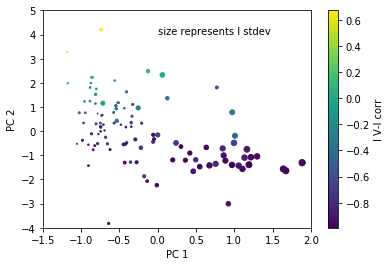

In [68]:
plt.scatter(pdf['pc 1'],pdf['pc 2'],s=100*df['stdev I'],c=df['I V-I corr']) #couldn't find column explaining PC2
plt.xlim(-1.5,2)
plt.ylim(-4,5)
plt.colorbar(label='I V-I corr')
plt.ylabel('PC 2')
plt.xlabel('PC 1')
plt.text(0,4,'size represents I stdev')
plt.savefig('Figs/PCAex.png',dpi=200,bbox_inches='tight')

Text(0.5, 0, 'I V-I corr')

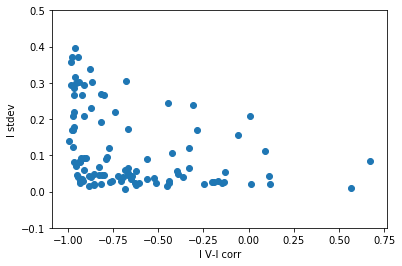

In [42]:
#plot correlation vs. stdev (or IQR)
plt.scatter(summ['I V-I corr'],summ['stdev I'])
plt.ylim(-0.1,0.5)
# plt.xscale('log')
# plt.yscale('log')
plt.ylabel('I stdev')
plt.xlabel('I V-I corr')

generally higher correlations when stdev higher

Text(0.5, 0, 'V V-I corr')

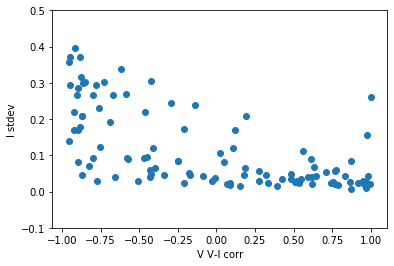

In [53]:
#plot correlation vs. stdev (or IQR)
plt.scatter(summ['V V-I corr'],summ['stdev I'])
plt.ylim(-0.1,0.5)
# plt.xscale('log')
# plt.yscale('log')
plt.ylabel('I stdev')
plt.xlabel('V V-I corr')

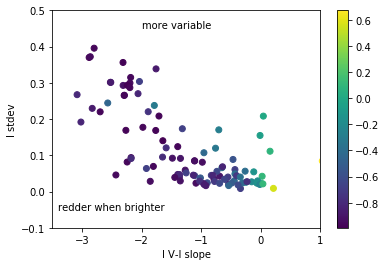

In [69]:
#plot correlation vs. stdev (or IQR)
plt.scatter(summ['I V-I slope'],summ['stdev I'],c=summ['I V-I corr'])
plt.ylim(-0.1,0.5) #note that two outliers cut out!
plt.xlim(-3.5,1)
plt.ylabel('I stdev')
plt.xlabel('I V-I slope')
plt.text(-2,0.45,'more variable')
plt.text(-3.4,-.05,'redder when brighter')
plt.colorbar()
# plt.savefig('Figs/stdev_slope.png',dpi=200,bbox_inches='tight')

In [70]:
df[:2]

,src_n,ra_deg,dec_deg,spin period,perr,est. period,sep,name,mean I,stdev I,...,V-I transition,Type II amp,note,I skew,I kurtosis,V skew,V kurtosis,best auto det pd,Part,I IQR
1,2,20.418930,-72.95907,2.165,2.0,84.00,2.147143,NaN,14.379506,0.356251,...,no,NaN,revisit alias and 6.8,0.768988,-1.033376,-1.537777,1.704585,83.985070,1.0,0.5845
2,3,13.639167,-73.68364,2.370,0.8,18.38,0.259701,NaN,14.877813,0.267369,...,yes,NaN,~1 day error on pd,1.698965,2.086592,1.458121,0.808846,17.404354,1.0,0.2325


In [71]:
p1 = pdf[pdf['Part']==1]
p2 = pdf[pdf['Part']==2]
p1f = df[df['Part']==1]
p2f = df[df['Part']==2]

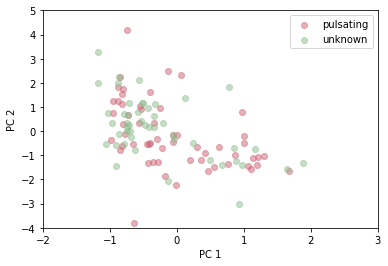

In [75]:
plt.scatter(p1['pc 1'],p1['pc 2'],color=pink,alpha=0.5,label='pulsating')
plt.scatter(p2['pc 1'],p2['pc 2'],color='darkseagreen',alpha=0.5,label='unknown') #,s=100*p2f['stdev I']

plt.xlim(-2,3)
plt.ylim(-4,5)
plt.ylabel('PC 2')
plt.xlabel('PC 1')
plt.legend()
# plt.savefig('Figs/PCA_parts.png',dpi=200,bbox_inches='tight')

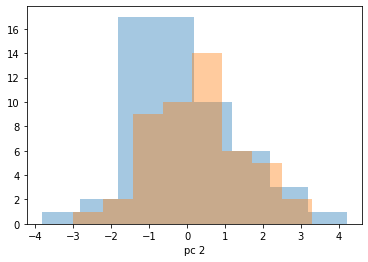

In [77]:
sb.distplot(p1['pc 2'],kde=False)
sb.distplot(p2['pc 2'],kde=False)

# just part 1 and use spin period

In [78]:
features = ['best auto det pd','spin period','mean I','stdev I','I range','I V-I corr','I V-I slope',
           'I skew','I kurtosis','I IQR']
df,pdf = fullpca(summ,features,5,retdf=True)

59
explained variance by component:[0.37822761 0.18247394 0.13229562 0.1013592  0.08707631]


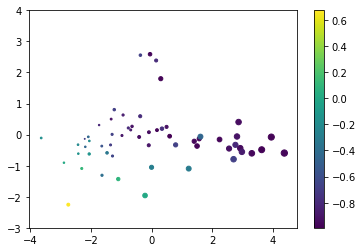

In [98]:
plt.scatter(pdf['pc 1'],pdf['pc 2'],c=df['I V-I corr'],s=100*df['stdev I'])
plt.ylim(-3,4)
plt.colorbar()

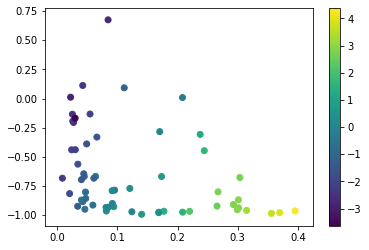

In [104]:
plt.scatter(df['stdev I'],df['I V-I corr'],c=pdf['pc 1'])
# plt.ylim(-3,4)
plt.colorbar()

In [114]:
summ.columns

Index(['src_n', 'ra_deg', 'dec_deg', 'spin period', 'perr', 'est. period',
       'sep', 'name', 'mean I', 'stdev I', 'max I', 'min I', 'I range',
       'mean V', 'stdev V', 'max V', 'min V', 'V range', 'est. period method',
       'best period', 'best superorbital', 'other period', 'period shape',
       'big dip', 'orbital cont', 'superorbital cont', 'mult superorbital',
       'changing superorbital amp', 'redder when brighter', 'I V-I corr',
       'V V-I corr', 'I V-I slope', 'I V-I int', 'V V-I slope', 'V V-I int',
       'V-I transition', 'Type II amp', 'note', 'I skew', 'I kurtosis',
       'V skew', 'V kurtosis', 'best auto det pd', 'Part', 'I IQR'],
      dtype='object')

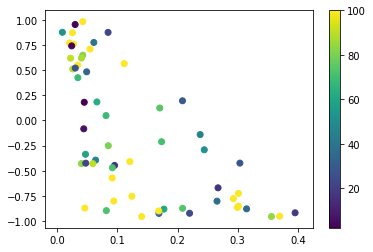

In [131]:
plt.scatter(df['stdev I'],df['V V-I corr'],c=df['best auto det pd'],vmax=100)
plt.colorbar()

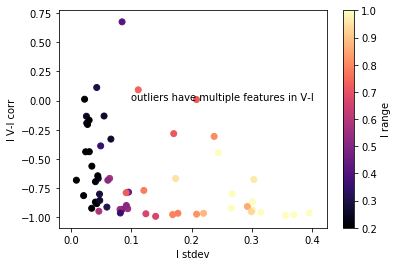

In [181]:
#maybe they have 
plt.scatter(df['stdev I'],df['I V-I corr'],c=df['I range'],vmin=0.2,vmax=1,cmap='magma')
plt.text(0.1,0,'outliers have multiple features in V-I')
plt.colorbar(label='I range')
plt.ylabel('I V-I corr')
plt.xlabel('I stdev')
# plt.savefig('Figs/slope_corr_outliers.png',dpi=200,bbox_inches='tight')

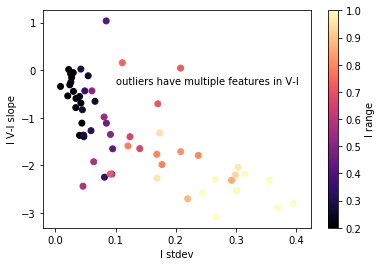

In [176]:
#outliers: not redder when brighter; higher range than stdev would imply b/c of large features
plt.scatter(df['stdev I'],df['I V-I slope'],c=df['I range'],vmin=0.2,vmax=1,cmap='magma')
plt.colorbar(label='I range')
plt.ylabel('I V-I slope')
plt.xlabel('I stdev')
plt.text(0.1,-0.3,'outliers have multiple features in V-I')
# plt.savefig('Figs/slope_stdev_outliers.png',dpi=200,bbox_inches='tight')

outliers
- range higher than may be expected by stdev
    - large features, singular, as you can see in LCs below
    - transitions in V-I plots
    - screenshot added to notes

In [136]:
out = summ[summ['stdev I']>0.15]
out = out[out['stdev I']<0.26]

In [137]:
out = out[out['I V-I corr']>-.75]
out = out[out['I V-I corr']<.25]

In [138]:
out = out[out['Part']==1]
out

,src_n,ra_deg,dec_deg,spin period,perr,est. period,sep,name,mean I,stdev I,...,V-I transition,Type II amp,note,I skew,I kurtosis,V skew,V kurtosis,best auto det pd,Part,I IQR
15,16,13.058333,-73.321660,15.30,1.00,74.51,0.357692,NaN,14.529405,0.170323,...,NaN,NaN,NaN,1.374265,0.875169,1.041327,-0.489576,74.295173,1.0,0.16000
31,35,16.930262,-71.998250,153.99,0.55,NaN,NaN,NaN,16.471812,0.244448,...,NaN,NaN,NaN,-1.001573,0.142835,-1.032533,-0.035612,51.374173,1.0,0.23775
37,41,12.546373,-73.006966,214.03,0.53,29.91,1.581483,NaN,15.280440,0.208182,...,NaN,NaN,NaN,1.044556,-0.510886,0.485326,-1.277231,29.900176,1.0,0.32400
45,50,13.217250,-72.287445,325.40,0.55,45.90,0.375830,NaN,16.563183,0.237613,...,NaN,NaN,NaN,-0.420659,-1.399838,-0.910813,-0.476956,45.948523,1.0,0.49050
52,57,13.897454,-72.485176,644.60,0.53,NaN,0.819181,NaN,14.667130,0.173403,...,NaN,NaN,NaN,1.972552,4.252006,0.575697,-0.929102,70.961479,1.0,0.16300


In [144]:
cross = Table.read('sourcefiles.csv')

In [153]:
out.loc[15]['src_n']

16

I and V-I correlation: -0.28392614544546685
V and V-I correlation: 0.1227097449647219
I and V-I correlation: -0.44719767996792303
V and V-I correlation: -0.2921974309963761
I and V-I correlation: 0.008207309264156904
V and V-I correlation: 0.1943980841976312
I and V-I correlation: -0.3076089999036358
V and V-I correlation: -0.14108535704213498
I and V-I correlation: -0.6687374569794301
V and V-I correlation: -0.21199712351210293


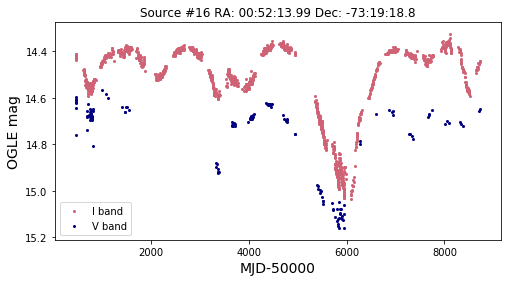

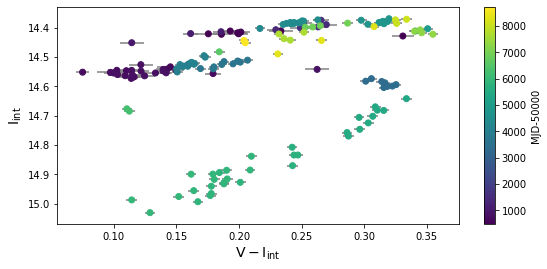

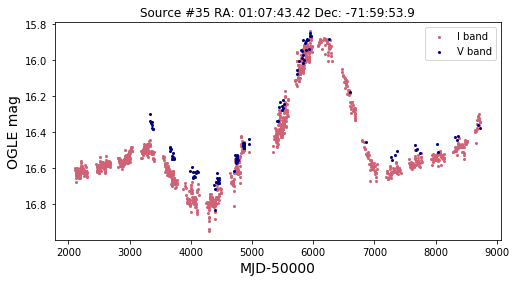

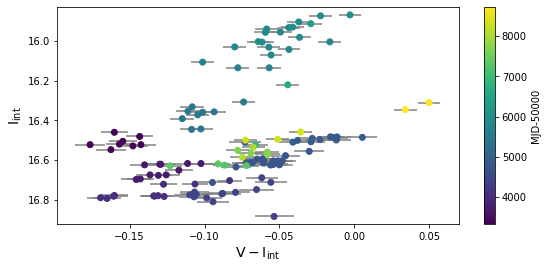

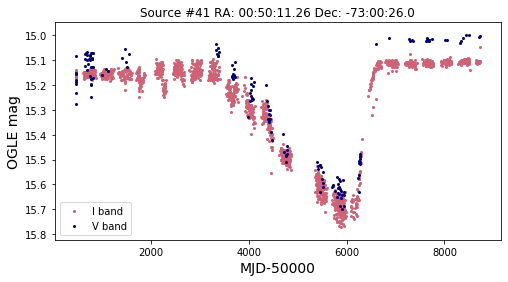

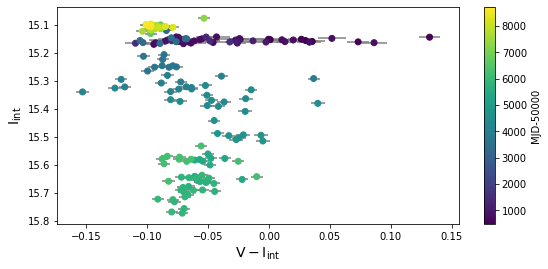

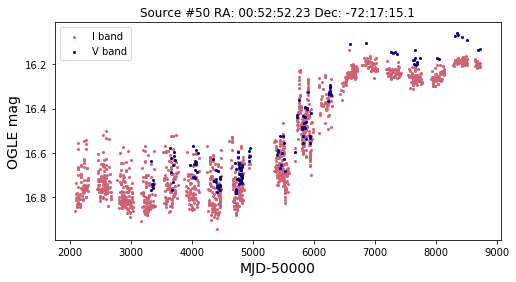

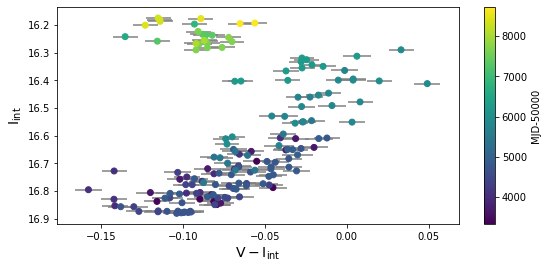

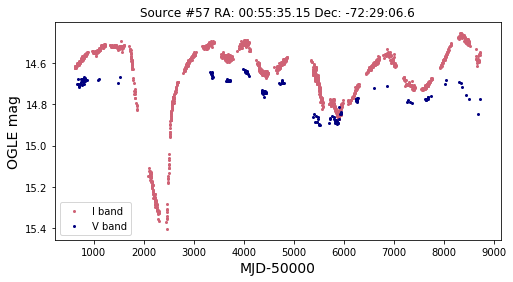

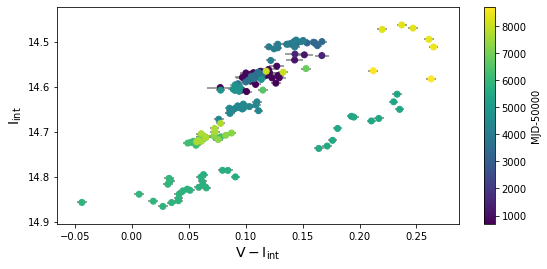

In [164]:
#plot each to look for anything in column
for i in [15,31,37,45,52]:
    iband,vband = o.getIV(out.loc[i]['src_n'],cross,plot=True,stack=True)
    #also plot color mag
    o.colormag(iband,vband,ctime=True,retint=False,figsize=(9,4),save=False,both=False) 


## PCA strategies
- can ultimately look at individual sources, but idea is that it's interesting to see how principal components correlate with certain columns
    - would have to see how heavily those columns are waited in principal components (i.e. linear coefficient used), but could say something about other correlations?
- probably important to get to higher explained variance in first component?
- add more variables esp. correlation ones (similar to hubble paper)

# PCA with phase tab, then with both

In [128]:
phase = pd.read_csv('phasetab.csv')

In [184]:
phase['period']

0             NaN
1       83.985070
2       17.404354
3       81.891818
4        2.233790
          ...    
104           NaN
105           NaN
106           NaN
107           NaN
108    119.667344
Name: period, Length: 109, dtype: float64

In [209]:
phase['symm sum'] /= phase['amp']

In [210]:
features = ['period','amp', 'phase diff','diff mean', 'mean', 'skew', 'kurtosis', 'symm sum','mean err']
df,pdf = fullpca(phase,features,5,retdf=True,addpart=False)

57
explained variance by component:[0.35513579 0.20999695 0.14091372 0.11403443 0.08767056]


### pc 1 is basically amplitude; not sure about 2

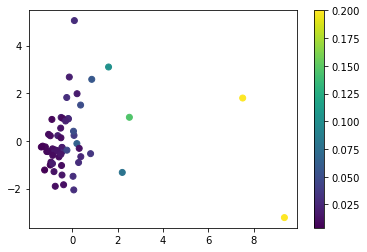

In [220]:
plt.scatter(pdf['pc 1'],pdf['pc 2'],c=df['amp'],vmax=0.2)
plt.colorbar()

In [246]:
# plt.scatter(phase['amp'],phase['mean err'],alpha=0.4)
# plt.ylim(0,.03)

(0, 0.16)

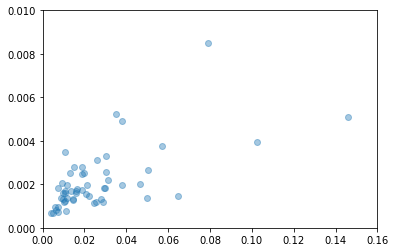

In [233]:
plt.scatter(phase['amp'],phase['mean err'],alpha=0.4)
plt.ylim(0,.01)
plt.xlim(0,.16) #see below: corr 0.72

In [236]:
phase.corr() #all correlations

,src_n,period,amp,phase diff,phase max,phase min,diff mean,mean,skew,kurtosis,symm sum,mean err
src_n,1.000000,0.169186,0.082715,-0.036054,-0.075489,0.115356,0.053488,-0.049997,-0.059743,-0.071106,-0.113983,0.037660
period,0.169186,1.000000,0.695700,0.159434,0.056715,0.065159,0.551572,0.139843,-0.200522,0.011610,-0.033736,0.319930
amp,0.082715,0.695700,1.000000,0.054363,0.016578,-0.015109,0.944192,0.168107,-0.294921,0.083375,-0.005275,0.725003
phase diff,-0.036054,0.159434,0.054363,1.000000,0.160003,0.135668,0.016659,-0.029392,-0.153994,0.148663,0.294262,-0.045161
phase max,-0.075489,0.056715,0.016578,0.160003,1.000000,-0.290128,0.068448,-0.011253,0.229048,-0.204124,0.134189,0.135349
phase min,0.115356,0.065159,-0.015109,0.135668,-0.290128,1.000000,-0.027945,0.107076,0.069493,-0.141196,0.092502,-0.052289
diff mean,0.053488,0.551572,0.944192,0.016659,0.068448,-0.027945,1.000000,0.131828,-0.128269,-0.041082,0.110682,0.886994
mean,-0.049997,0.139843,0.168107,-0.029392,-0.011253,0.107076,0.131828,1.000000,0.093556,0.087284,0.033932,0.033296
skew,-0.059743,-0.200522,-0.294921,-0.153994,0.229048,0.069493,-0.128269,0.093556,1.000000,-0.689672,0.203181,-0.047743
kurtosis,-0.071106,0.011610,0.083375,0.148663,-0.204124,-0.141196,-0.041082,0.087284,-0.689672,1.000000,-0.287231,-0.099883


Text(0, 0.5, 'Kurtosis')

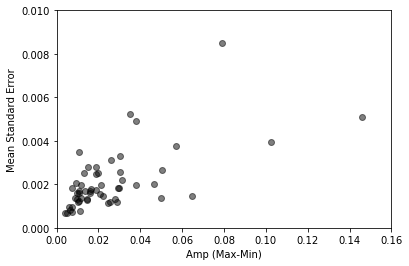

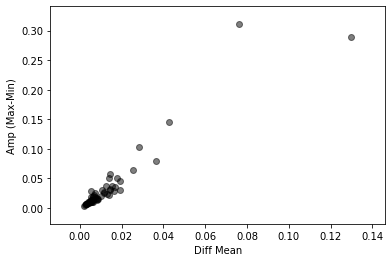

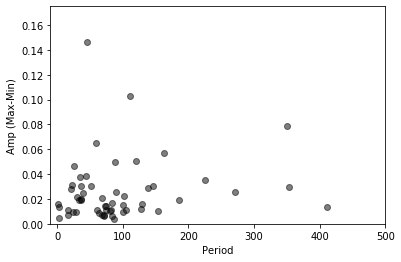

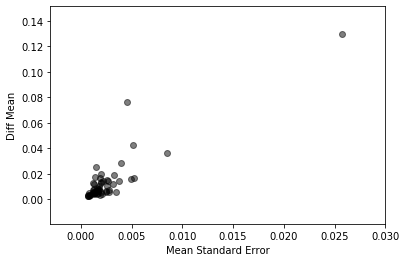

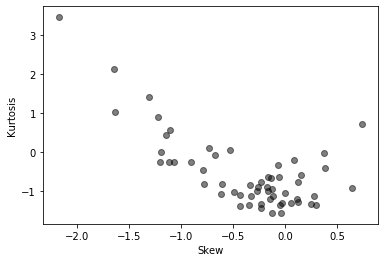

In [263]:
#plot all decent correlations
plt.figure(figsize=(6,4))
plt.scatter(phase['amp'],phase['mean err'],alpha=0.5,color='black')
plt.ylim(0,.01)
plt.xlim(0,.16)
plt.xlabel('Amp (Max-Min)')
plt.ylabel('Mean Standard Error')

plt.figure(figsize=(6,4))
plt.scatter(phase['diff mean'],phase['amp'],color='black',alpha=0.5)
plt.xlabel('Diff Mean')
plt.ylabel('Amp (Max-Min)')

plt.figure(figsize=(6,4))
plt.scatter(phase['period'],phase['amp'],color='black',alpha=0.5)
#cutting out outliers to zoom in
plt.ylim(0,0.175)
plt.xlim(-10,500)
plt.ylabel('Amp (Max-Min)')
plt.xlabel('Period')

plt.figure(figsize=(6,4))
plt.scatter(phase['mean err'],phase['diff mean'],color='black',alpha=0.5)
plt.xlim(-.003,0.03)
plt.xlabel('Mean Standard Error')
plt.ylabel('Diff Mean')

plt.figure(figsize=(6,4))
plt.scatter(phase['skew'],phase['kurtosis'],color='black',alpha=0.5)
plt.xlabel('Skew')
plt.ylabel('Kurtosis')

# PCA on Combined Tables
- repeat once part 2 sources added

In [266]:
jointab = pd.concat([phase, summ], axis=1, join="inner")

In [267]:
jointab

,src_n,period,amp,phase diff,phase max,phase min,shape,diff mean,mean,skew,...,V-I transition,Type II amp,note,I skew,I kurtosis,V skew,V kurtosis,best auto det pd,Part,I IQR
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
1,2,83.985070,0.016494,0.3750,0.84375,0.46875,not FRED,0.007994,14.376809,-0.129870,...,no,NaN,revisit alias and 6.8,0.768988,-1.033376,-1.537777,1.704585,83.985070,1.0,0.58450
2,3,17.404354,0.007245,0.3750,0.03125,0.65625,FRED,0.003236,14.874752,-0.146747,...,yes,NaN,~1 day error on pd,1.698965,2.086592,1.458121,0.808846,17.404354,1.0,0.23250
3,4,81.891818,0.011105,0.6250,0.34375,0.71875,not FRED,0.004500,13.918744,-0.612346,...,yes,0.030,possible drift,1.061946,0.298944,0.799828,1.009136,81.891818,1.0,0.05100
4,5,2.233790,0.015933,0.3125,0.21875,0.90625,FRED,0.008337,15.548018,-0.162822,...,no,0.133,"0.39,9.5,50.5,70.3 other possible",-0.257503,1.181314,-0.241179,0.598523,2.233790,1.0,0.04200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.098829,-1.408450,0.273955,-1.734110,120.604870,2.0,0.38700
105,138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.448554,0.283552,-7.292278,71.456149,2.140374,2.0,0.01875
106,139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.107101,-0.592761,0.388651,-0.070643,84.159974,2.0,0.03000
107,141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.301821,-0.210804,0.279669,-0.494353,5.183714,2.0,0.03100


In [393]:
features = ['spin period','period','amp', 'phase diff','diff mean','skew','kurtosis', 'symm sum','mean err','stdev I','I V-I corr','I skew','I kurtosis','mean I']
df,pdf = fullpca(jointab,features,5,retdf=True,addpart=False)

55
explained variance by component:[0.23915637 0.15657598 0.12989407 0.11345673 0.08175213]


Text(4, 4, 'size is folded max-min')

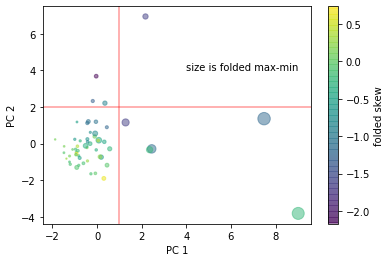

In [394]:
plt.scatter(pdf['pc 1'],pdf['pc 2'],s=500*df['amp'],c=df['skew'],alpha=0.5)
plt.axvline(1,color='red',alpha=0.4)
plt.axhline(2,color='red',alpha=0.4)
plt.ylabel('PC 2')
plt.xlabel('PC 1')
plt.colorbar(label='folded skew')
plt.text(4,4,'size is folded max-min')

In [288]:
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')

Text(0.5, 0, 'PC 1')

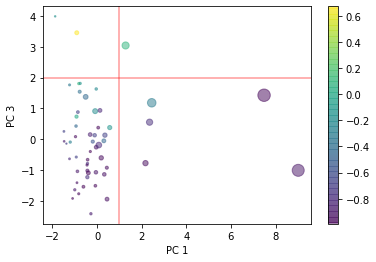

In [397]:
plt.scatter(pdf['pc 1'],pdf['pc 3'],s=500*df['amp'],c=df['I V-I corr'],alpha=0.5)
plt.colorbar()
plt.axvline(1,color='red',alpha=0.4)
plt.axhline(2,color='red',alpha=0.4)
plt.ylabel('PC 3')
plt.xlabel('PC 1')

In [383]:
features

['period',
 'amp',
 'phase diff',
 'diff mean',
 'skew',
 'kurtosis',
 'symm sum',
 'mean err',
 'stdev I',
 'I V-I corr',
 'I skew',
 'I kurtosis',
 'mean I']

Text(0.5, 0, 'PC 1')

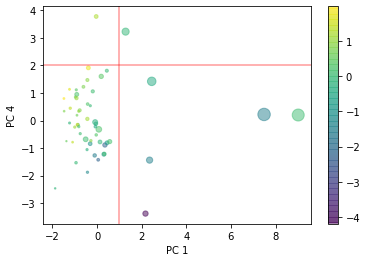

In [398]:
plt.scatter(pdf['pc 1'],pdf['pc 4'],s=500*df['amp'],c=df['I skew'],alpha=0.5)
plt.colorbar()
plt.axvline(1,color='red',alpha=0.4)
plt.axhline(2,color='red',alpha=0.4)
plt.ylabel('PC 4')
plt.xlabel('PC 1')

approximate pc explanations
- 1: amplitude
- 2: skew (though it's kind of on the diagonal so could be something else)
- 3: I V-I corr
- 4: I skew on a negative diagonal
- these are loose; changed a bit when spin period added

pc 1 outliers have high phase-folded amplitudes

In [334]:
def outliers(cut,pc=1):
    #table with outliers
    out = pdf[pdf[f'pc {pc}']>cut]
    #get source numbers from df
    oinds = out.index
    srcns = df.loc[oinds]['src_n']
    pds = np.array(df.loc[oinds]['period'])
    nums = np.array(srcns['src_n'])[:,0]
    for i in range(len(nums)):
        iband,vband = o.getIV(nums[i],cross,stack=True,plot=True)
        #also plot color mag
        o.colormag(iband,vband,ctime=True,retint=False,figsize=(9,4),save=False,both=False)
        o.splinedetrend(iband,window=100)
        #phase-fold with period used
        plt.figure(figsize=(5,4))
        o.phasestep(iband,pds[i],16,det=True,double=True,color='black',err=True,retall=False,epoch=0,sterr=True,divide=True)
    return out

In [399]:
# outliers(1)

In [380]:
# outliers(2,pc=2) #highly variable

In [379]:
# outliers(2,pc=3) #peaky phase folds?

In [401]:
# corner plot with features for part 1 -- tough b/c of outliers
# c = sb.pairplot(jointab,vars=features,corner=True,palette=['darkseagreen'])

In [407]:
features


['spin period',
 'period',
 'amp',
 'phase diff',
 'diff mean',
 'skew',
 'kurtosis',
 'symm sum',
 'mean err',
 'stdev I',
 'I V-I corr',
 'I skew',
 'I kurtosis',
 'mean I']

In [417]:
#smaller jointab just with features
feat = pd.DataFrame(columns=features)
feat['spin period'] = jointab['spin period']
for f in features:
    feat[f] = jointab[f]

In [418]:
feat.corr() #no new correlations found (i.e. none between variables describing full LC and those describing phase-folded data)

,spin period,period,amp,phase diff,diff mean,skew,kurtosis,symm sum,mean err,stdev I,I V-I corr,I skew,I kurtosis,mean I
spin period,1.000000,0.000247,-0.042663,0.005382,-0.051676,0.065558,-0.132156,-0.198676,-0.053482,-0.240184,0.222858,-0.129055,0.124942,-0.035049
period,0.000247,1.000000,0.695700,0.159434,0.551572,-0.200522,0.011610,-0.033736,0.319930,-0.059365,-0.128563,-0.254320,0.049635,0.137792
amp,-0.042663,0.695700,1.000000,0.054363,0.944192,-0.294921,0.083375,-0.005275,0.725003,0.115416,-0.029648,-0.275253,0.036380,0.167794
phase diff,0.005382,0.159434,0.054363,1.000000,0.016659,-0.153994,0.148663,0.294262,-0.045161,-0.106085,-0.384962,-0.139961,0.218860,-0.029920
diff mean,-0.051676,0.551572,0.944192,0.016659,1.000000,-0.128269,-0.041082,0.110682,0.886994,0.162384,-0.021371,-0.231702,-0.017576,0.131074
skew,0.065558,-0.200522,-0.294921,-0.153994,-0.128269,1.000000,-0.689672,0.203181,-0.047743,0.089121,0.101966,0.123850,-0.280750,0.091174
kurtosis,-0.132156,0.011610,0.083375,0.148663,-0.041082,-0.689672,1.000000,-0.287231,-0.099883,-0.018087,0.035610,-0.033148,0.240253,0.089211
symm sum,-0.198676,-0.033736,-0.005275,0.294262,0.110682,0.203181,-0.287231,1.000000,0.240458,0.157999,-0.209124,-0.058665,-0.027154,0.033497
mean err,-0.053482,0.319930,0.725003,-0.045161,0.886994,-0.047743,-0.099883,0.240458,1.000000,0.262978,-0.030089,-0.144939,-0.003446,0.032398
stdev I,-0.240184,-0.059365,0.115416,-0.106085,0.162384,0.089121,-0.018087,0.157999,0.262978,1.000000,-0.059778,-0.040662,-0.105162,0.221299
